This series of Notebooks will guide you through the simulation and analysis of near-infrared (NIR) high-resolution spectroscopy (HRS) data of exoplanet atmospheres. 

## Part 2 - The analysis

Now that we have got a synthetic dataset incorporating the planet spectrum, the telluric spectrum, and instrumental throughput, we will see what the standard analysis does to the data to "reverse-engineer" the process and get rid of these instrumental / telluric effects while preserving the planet signal.

In [1]:
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
import simulator_code as sim

Let us reload the full data matrix and the corresponding wavelengths.

In [3]:
wData = np.load('wlen_regr.npy')
fData = np.load('output/ffake_with_noise.npy')

The first step that we want to achieve is to correct for the variable throughput of the instrument, which is well visible as a series of horizontal stripes in the data matrix. Let us look again, for instance, at the first CRIRES detector:

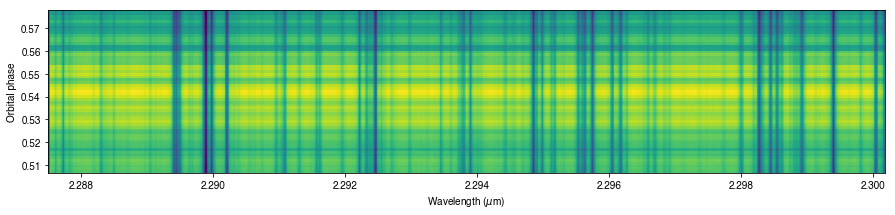

In [4]:
spec = fData[0,].copy()
wlen = wData[0,].copy() / 1E3    # In micron
ph = np.load('ph.npy')
plt.figure(figsize=(15,3))
lims = [wlen[0],wlen[-1],ph[0],ph[-1]]
plt.imshow(spec,origin='lower',extent=lims,aspect='auto')
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Orbital phase')
plt.show()

To correct for the variable throughput, we can measure the level of the continuum in each of the spectra in the sequence, and divide through it. To get a reliable estimate of the continuum, we will take the average (in wavelength) of the brightest 300 pixels.

In [5]:
no, nf, nx = fData.shape        # N.detectors, N.spectra, N.spectral channels
# Looping over detectors
for io in range(no):
    avgSpec = np.nanmean(fData[io,],axis=0)     # Time-averaged spectrum (use median if bad pixels are present)
    isort = np.argsort(avgSpec)                 # Sorted indices of the average spectrum
    # Looping over each observed spectrum in the sequence
    for j in range(nf):
        fData[io,j,] /= np.nanmedian(fData[io,j,isort[nx-310:nx-10]])

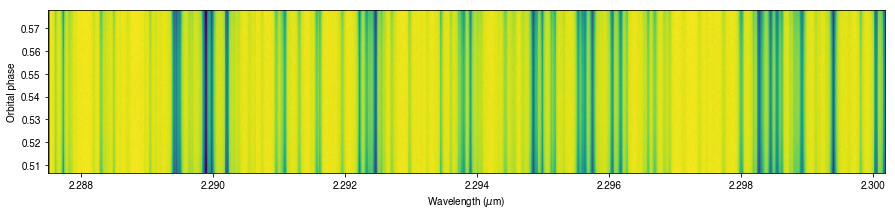

In [6]:
spec = fData[0,].copy()
plt.figure(figsize=(15,3))
plt.imshow(spec,origin='lower',extent=lims,aspect='auto')
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Orbital phase')
plt.show()

In Part 1 we have simulated the Earth's atmospheric transparency by using a model for the sky above Cerro Paranal which incorporates the effects of variable airmass. This is the most fundamental parameter driving the variation in depth of telluric lines. If I plot for instance the time-variations of the flux in the core of a telluric absorption line (in blue) and I compare it to a region of the continuum (in orange):

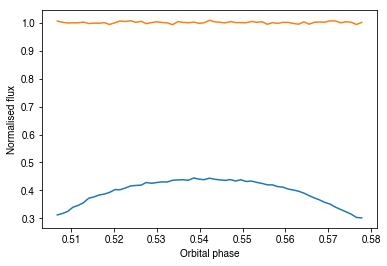

In [7]:
#plt.plot(fData[0,0,180:300])
plt.plot(ph,fData[0,:,200])         # Telluric line at 2.29 micron
plt.plot(ph,fData[0,:,240])         # Continuum flux redwards of telluric line
plt.xlabel('Orbital phase')
plt.ylabel('Normalised flux')
plt.show()

Theoretically, if the opacity in the Earth's atmosphere does not change with time (i.e. if the humidity stays constant) the flux received should just depend on the exponential of the geometric airmass, because the optical depth will be proportional to the airmass itself. Therefore, we can try to detrend the flux in each column of the data matrix (i.e. each spectral channel) via a linear fit with the exponential of the airmass.

In [8]:
air = np.load('air.npy')               # Loading the airmass vector
expAir = air#np.exp(air)
tellRem = fData.copy()
# Looping over detectors
for io in range(no):
    # Looping over spectra
    for i in range(nx):
        pars = np.polyfit(expAir, tellRem[io,:,i], 2)
        fitFunc = np.poly1d(pars)
        fit = fitFunc(expAir)
        tellRem[io,:,i] /= fit

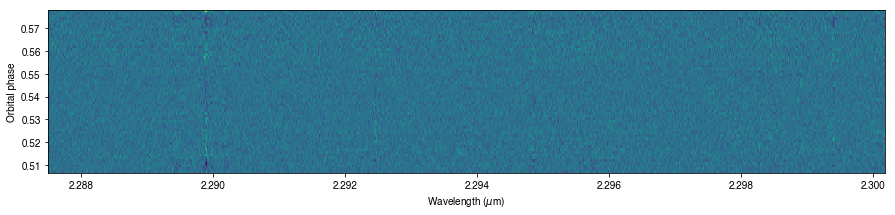

In [9]:
spec = tellRem[0,].copy()
plt.figure(figsize=(15,3))
plt.imshow(spec,origin='lower',extent=lims,aspect='auto')
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Orbital phase')
plt.show()

The first time that we run the code above, we tried the 1st order airmass, but it did not work. This is because when we modelled the telluric absorption we scaled the telluric spectrum to real observed spectra. The latter almost always suffer from small changes of the water vapour content in time, therefore the telluric lines will not exactly follow airmass. Using a higher order polynomial fit (2nd degree in this case) solves the problem in the majority of cases when the weather is stable (hence temporal changes are smooth).

The other detail that you probably noticed is that the data is noisier at the position of telluric lines. This is also normal, because under poisson statistics (obeyed by photons) the error is the square root of the count rate, hence the relative error will grow for small fluxes (the core of telluric lines) relative to big fluxes (the continuum). To weight down these noisy columns and possible columns where the telluric detrending has not gone well, we can divide each column by its standard deviation.

In [11]:
# Subtracting 1 from the matrix because we just want to work with the width of the noise distribution, not the mean
tellRem -= 1.0
# Computing the standard deviation along the time direction
stdMat = np.std(tellRem, axis=1)
# Looping over detectors
for io in range(no):
    # Looping over wavelength
    for i in range(nx):
        if stdMat[io,i] != 0:
            tellRem[io,:,i] /= stdMat[io,i]
np.save('output/tsub.npy', tellRem)       # Saving results for subsequent use

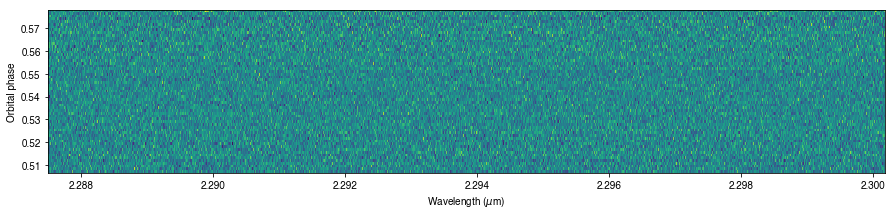

In [12]:
spec = tellRem[0,].copy()
plt.figure(figsize=(15,3))
plt.imshow(spec,origin='lower',extent=lims,aspect='auto')
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Orbital phase')
plt.show()

And we are done! Depending on the level of the injected model spectrum, you might be able to see some slanted spectral lines at this stage. However, in realistic datasets (at least as far as current telescopes go), each planet line has a S/N < 1 at this stage, so it should not be visible.